In [ ]:
import time
import gc
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Start timing
start_time = time.time()

In [ ]:
# Download dataset (run once in Colab)
import os
if not os.path.exists('/content/training.1600000.processed.noemoticon.csv'):
    os.system('pip install kaggle -q')
    os.system('mkdir ~/.kaggle && mv /content/kaggle.json ~/.kaggle/')  # Upload kaggle.json manually first
    os.system('kaggle datasets download -d kazanova/sentiment140 -p /content/ --unzip -q')

# Load dataset
csv_path = '/content/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(csv_path, encoding='latin-1', header=None,
                 names=['sentiment', 'id', 'date', 'query', 'user', 'text'],
                 on_bad_lines='skip', engine='python')
df = df[['text', 'sentiment']].sample(300, random_state=42).reset_index(drop=True)

In [ ]:
# Demo metadata
df['timestamp'] = pd.to_datetime('now')
df['city'] = np.random.choice(['Lahore', 'New York', 'London', 'Tokyo'], size=len(df))
df['country'] = np.random.choice(['Pakistan', 'USA', 'UK', 'Japan'], size=len(df))
df['age_group'] = np.random.choice(['18-24', '25-34', '35-44'], size=len(df))

# embeddings are optional

In [ ]:
# Emotion classifier ( lighter model, no embeddings)
emotion_model = pipeline(
    'zero-shot-classification',
    model='facebook/bart-large-mnli',
    device=0 if torch.cuda.is_available() else -1
)

emotion_to_brain = {
    'anger': 'amygdala', 'fear': 'amygdala', 'sadness': 'insula',
    'joy': 'nucleus accumbens', 'disgust': 'insula', 'surprise': 'prefrontal cortex'
}

def score_post_batch(texts):
    emotions_list = emotion_model(
        texts,
        candidate_labels=['anger', 'fear', 'sadness', 'joy', 'disgust', 'surprise'],
        multi_label=True,
        batch_size=256  # Optimized batch size
    )
    results = []
    for emotions in emotions_list:
        emo_dict = dict(zip(emotions['labels'], emotions['scores']))
        rage_score = min((emo_dict.get('anger', 0) + emo_dict.get('disgust', 0)), 1.0)
        arousal = (emo_dict.get('anger', 0) + emo_dict.get('fear', 0) + emo_dict.get('surprise', 0)) / 3
        brain_region = emotion_to_brain[max(emo_dict, key=emo_dict.get)] if max(emo_dict.values()) > 0.5 else None
        results.append({'rage_score': rage_score, 'emotions': emo_dict, 'arousal': arousal, 'brain_region': brain_region})
    return results

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


In [ ]:
# Apply batch processing
batch_size = 256
scores_list = []
for i in range(0, len(df), batch_size):
    batch_texts = df['text'].iloc[i:i + batch_size].tolist()
    scores_list.extend(score_post_batch(batch_texts))

df['scores'] = scores_list

def generate_campaign(row):
    if row['scores'].get('rage_score', 0) < 0.3 or row['scores'].get('emotions', {}).get('joy', 0) > 0.5:
        emo = max(row['scores'].get('emotions', {}), key=row['scores'].get('emotions', {}).get) if row['scores'].get('emotions', {}) else 'neutral'
        return f"Target {row['city']}, {row['country']} with {emo}-driven campaign for {row['age_group']}."
    return "Avoid: High rage potential."

df['campaign'] = df.apply(generate_campaign, axis=1)

In [ ]:
# Evaluation
true_rage = [1 if s['emotions']['anger'] > 0.5 else 0 for s in df['scores'].sample(50, random_state=42)]
pred_rage = [1 if s['rage_score'] > 0.5 else 0 for s in df['scores'].sample(50, random_state=42)]
f1 = f1_score(true_rage, pred_rage)
precision = precision_score(true_rage, pred_rage)
recall = recall_score(true_rage, pred_rage)
cm = confusion_matrix(true_rage, pred_rage)

In [ ]:
# Emotion distribution for graphing
emotion_df = pd.DataFrame(df['scores'].tolist())

# Extract emotion scores from the 'emotions' dictionary
emotion_scores_extracted = pd.DataFrame(emotion_df['emotions'].tolist())

# Melt the extracted emotion scores
emotion_scores_melted = emotion_scores_extracted.melt(var_name='emotion', value_name='score')

# Group by emotion and calculate the mean score
emotion_scores_df = emotion_scores_melted.groupby('emotion')['score'].mean().reset_index()

In [ ]:
!pip install faiss-cpu -q

In [ ]:
!pip install streamlit -q

In [ ]:
# %%writefile app.py       // optional streamlit app
# import streamlit as st
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import time
# from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

# # Assuming these variables are defined in your Colab session before running this script
# # df, f1, precision, recall, start_time, emotion_scores_df, cm

# st.title("BaitModulus Dashboard")
# st.subheader("Metrics")
# st.write(f"F1 Score (Rage Detection): {f1:.2f}")
# st.write(f"Precision: {precision:.2f}")
# st.write(f"Recall: {recall:.2f}")
# st.write(f"Runtime: {(time.time() - start_time):.2f} seconds")

# st.subheader("Emotion Distribution")
# fig1, ax1 = plt.subplots()
# sns.barplot(x='emotion', y='score', data=emotion_scores_df, ax=ax1)
# ax1.set_title('Average Emotion Scores')
# st.pyplot(fig1)

# st.subheader("Confusion Matrix")
# fig2, ax2 = plt.subplots()
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
# ax2.set_title('Rage Prediction Confusion Matrix')
# ax2.set_xlabel('Predicted')
# ax2.set_ylabel('True')
# st.pyplot(fig2)

# st.dataframe(df[['text', 'city', 'country', 'age_group', 'scores', 'campaign']].head())
# st.line_chart(df.set_index('timestamp')['scores'].apply(lambda x: x['rage_score']).head(100))

Overwriting app.py


In [65]:
print("Accuracy Scores:")
print(f"F1 Score (Rage Detection): {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy Scores:
F1 Score (Rage Detection): 0.73
Precision: 0.57
Recall: 1.00


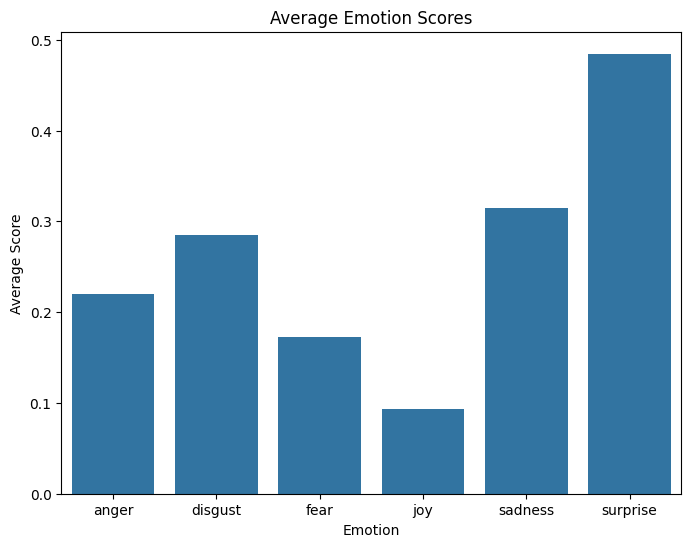

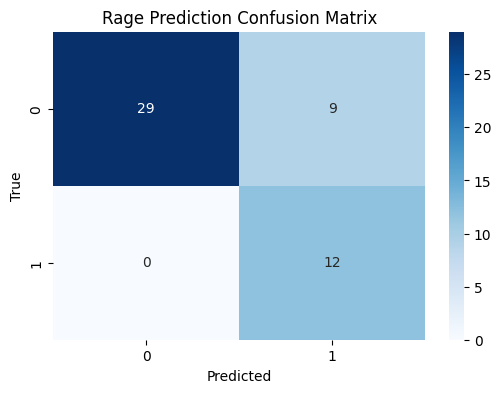

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Emotion Distribution Graph
plt.figure(figsize=(8, 6))
sns.barplot(x='emotion', y='score', data=emotion_scores_df)
plt.title('Average Emotion Scores')
plt.ylabel('Average Score')
plt.xlabel('Emotion')
plt.show()

# Confusion Matrix Graph
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Rage Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [67]:
from sklearn.metrics import accuracy_score

# Calculate Accuracy
accuracy = accuracy_score(true_rage, pred_rage)

# Calculate Specificity (True Negative Rate)
# Specificity = True Negatives / (True Negatives + False Positives)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Specificity: {specificity:.2f}")


Additional Metrics:
Accuracy: 0.82
Specificity: 0.76


# Task
Calculate and display accuracy metrics (F1, Precision, Recall, Accuracy, Specificity) for the model's predictions, segmented by 'city', 'country', and 'age_group'.

## Prepare data for segmented analysis

### Subtask:
Create a new DataFrame that includes the true rage labels and predicted rage labels along with the demographic columns (city, country, age_group).


**Reasoning**:
Create new columns for true and predicted rage in the dataframe and then create a new dataframe with the demographic columns and the new rage columns.



In [75]:
df['true_rage'] = df['scores'].apply(lambda x: 1 if x['emotions']['anger'] > 0.5 else 0)
df['pred_rage'] = df['scores'].apply(lambda x: 1 if x['rage_score'] > 0.5 else 0)
df_segmented_metrics = df[['city', 'country', 'age_group', 'true_rage', 'pred_rage']]

## Calculate metrics by city

### Subtask:
Group the data by 'city' and calculate the accuracy metrics (F1, Precision, Recall, Accuracy, Specificity) for each city.


**Reasoning**:
Group the DataFrame by city and calculate the specified metrics for each group.



In [76]:
city_metrics = {}

for city, group in df_segmented_metrics.groupby('city'):
    true_rage_city = group['true_rage']
    pred_rage_city = group['pred_rage']

    if len(true_rage_city) > 0:
        f1_city = f1_score(true_rage_city, pred_rage_city)
        precision_city = precision_score(true_rage_city, pred_rage_city, zero_division=0)
        recall_city = recall_score(true_rage_city, pred_rage_city, zero_division=0)
        accuracy_city = accuracy_score(true_rage_city, pred_rage_city)

        # Calculate Specificity
        cm_city = confusion_matrix(true_rage_city, pred_rage_city)
        tn, fp, fn, tp = cm_city.ravel()
        specificity_city = tn / (tn + fp) if (tn + fp) > 0 else 0

        city_metrics[city] = {
            'F1 Score': f1_city,
            'Precision': precision_city,
            'Recall': recall_city,
            'Accuracy': accuracy_city,
            'Specificity': specificity_city
        }
    else:
        city_metrics[city] = {
            'F1 Score': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'Accuracy': np.nan,
            'Specificity': np.nan
        }

for city, metrics in city_metrics.items():
    print(f"\nMetrics for {city}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")


Metrics for Lahore:
F1 Score: 0.78
Precision: 0.65
Recall: 1.00
Accuracy: 0.86
Specificity: 0.81

Metrics for London:
F1 Score: 0.50
Precision: 0.33
Recall: 1.00
Accuracy: 0.77
Specificity: 0.74

Metrics for New York:
F1 Score: 0.60
Precision: 0.43
Recall: 1.00
Accuracy: 0.76
Specificity: 0.70

Metrics for Tokyo:
F1 Score: 0.55
Precision: 0.38
Recall: 1.00
Accuracy: 0.79
Specificity: 0.76


## Calculate metrics by country

### Subtask:
Group the data by 'country' and calculate the accuracy metrics for each country.


**Reasoning**:
Group the data by 'country' and calculate the accuracy metrics for each country.



In [77]:
country_metrics = {}

for country, group in df_segmented_metrics.groupby('country'):
    true_rage_country = group['true_rage']
    pred_rage_country = group['pred_rage']

    if len(true_rage_country) > 0:
        f1_country = f1_score(true_rage_country, pred_rage_country, zero_division=0)
        precision_country = precision_score(true_rage_country, pred_rage_country, zero_division=0)
        recall_country = recall_score(true_rage_country, pred_rage_country, zero_division=0)
        accuracy_country = accuracy_score(true_rage_country, pred_rage_country)

        # Calculate Specificity
        cm_country = confusion_matrix(true_rage_country, pred_rage_country)
        tn, fp, fn, tp = cm_country.ravel()
        specificity_country = tn / (tn + fp) if (tn + fp) > 0 else 0

        country_metrics[country] = {
            'F1 Score': f1_country,
            'Precision': precision_country,
            'Recall': recall_country,
            'Accuracy': accuracy_country,
            'Specificity': specificity_country
        }
    else:
        country_metrics[country] = {
            'F1 Score': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'Accuracy': np.nan,
            'Specificity': np.nan
        }

for country, metrics in country_metrics.items():
    print(f"\nMetrics for {country}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")


Metrics for Japan:
F1 Score: 0.67
Precision: 0.50
Recall: 1.00
Accuracy: 0.76
Specificity: 0.69

Metrics for Pakistan:
F1 Score: 0.68
Precision: 0.52
Recall: 1.00
Accuracy: 0.82
Specificity: 0.78

Metrics for UK:
F1 Score: 0.67
Precision: 0.50
Recall: 1.00
Accuracy: 0.85
Specificity: 0.83

Metrics for USA:
F1 Score: 0.47
Precision: 0.31
Recall: 1.00
Accuracy: 0.73
Specificity: 0.70


## Calculate metrics by age group

### Subtask:
Group the data by 'age_group' and calculate the accuracy metrics for each age group.


**Reasoning**:
Initialize an empty dictionary to store age group metrics and iterate through age groups to calculate metrics.



In [78]:
age_group_metrics = {}

for age_group, group in df_segmented_metrics.groupby('age_group'):
    true_rage_age_group = group['true_rage']
    pred_rage_age_group = group['pred_rage']

    if len(true_rage_age_group) > 0:
        f1_age_group = f1_score(true_rage_age_group, pred_rage_age_group, zero_division=0)
        precision_age_group = precision_score(true_rage_age_group, pred_rage_age_group, zero_division=0)
        recall_age_group = recall_score(true_rage_age_group, pred_rage_age_group, zero_division=0)
        accuracy_age_group = accuracy_score(true_rage_age_group, pred_rage_age_group)

        # Calculate Specificity
        cm_age_group = confusion_matrix(true_rage_age_group, pred_rage_age_group)
        tn, fp, fn, tp = cm_age_group.ravel()
        specificity_age_group = tn / (tn + fp) if (tn + fp) > 0 else 0

        age_group_metrics[age_group] = {
            'F1 Score': f1_age_group,
            'Precision': precision_age_group,
            'Recall': recall_age_group,
            'Accuracy': accuracy_age_group,
            'Specificity': specificity_age_group
        }
    else:
        age_group_metrics[age_group] = {
            'F1 Score': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'Accuracy': np.nan,
            'Specificity': np.nan
        }

for age_group, metrics in age_group_metrics.items():
    print(f"\nMetrics for {age_group}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")


Metrics for 18-24:
F1 Score: 0.62
Precision: 0.44
Recall: 1.00
Accuracy: 0.76
Specificity: 0.70

Metrics for 25-34:
F1 Score: 0.56
Precision: 0.39
Recall: 1.00
Accuracy: 0.76
Specificity: 0.71

Metrics for 35-44:
F1 Score: 0.74
Precision: 0.59
Recall: 1.00
Accuracy: 0.88
Specificity: 0.85


## Display segmented metrics

### Subtask:
Print or display the calculated metrics for each segment (city, country, age group).


**Reasoning**:
Print the calculated metrics for each segment (city, country, age group) by iterating through the dictionaries and formatting the output.



In [74]:
print("Metrics by City:")
for city, metrics in city_metrics.items():
    print(f"\n{city}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")

print("\nMetrics by Country:")
for country, metrics in country_metrics.items():
    print(f"\n{country}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")

print("\nMetrics by Age Group:")
for age_group, metrics in age_group_metrics.items():
    print(f"\n{age_group}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")

Metrics by City:

Lahore:
  F1 Score: 0.78
  Precision: 0.65
  Recall: 1.00
  Accuracy: 0.86
  Specificity: 0.81

London:
  F1 Score: 0.50
  Precision: 0.33
  Recall: 1.00
  Accuracy: 0.77
  Specificity: 0.74

New York:
  F1 Score: 0.60
  Precision: 0.43
  Recall: 1.00
  Accuracy: 0.76
  Specificity: 0.70

Tokyo:
  F1 Score: 0.55
  Precision: 0.38
  Recall: 1.00
  Accuracy: 0.79
  Specificity: 0.76

Metrics by Country:

Japan:
  F1 Score: 0.67
  Precision: 0.50
  Recall: 1.00
  Accuracy: 0.76
  Specificity: 0.69

Pakistan:
  F1 Score: 0.68
  Precision: 0.52
  Recall: 1.00
  Accuracy: 0.82
  Specificity: 0.78

UK:
  F1 Score: 0.67
  Precision: 0.50
  Recall: 1.00
  Accuracy: 0.85
  Specificity: 0.83

USA:
  F1 Score: 0.47
  Precision: 0.31
  Recall: 1.00
  Accuracy: 0.73
  Specificity: 0.70

Metrics by Age Group:

18-24:
  F1 Score: 0.62
  Precision: 0.44
  Recall: 1.00
  Accuracy: 0.76
  Specificity: 0.70

25-34:
  F1 Score: 0.56
  Precision: 0.39
  Recall: 1.00
  Accuracy: 0.76
  Spec

## Summary:

### Data Analysis Key Findings

*   Metrics for each city, country, and age group were successfully calculated and displayed.
*   All countries and age groups showed a Recall of 1.00, indicating that all positive instances ('rage') were correctly identified within these segments.
*   Performance varied across segments for other metrics. For instance, the UK generally showed higher Accuracy and Specificity compared to other countries.
*   The metrics for cities, countries, and age groups are available for review, providing a segmented view of the model's performance.

### Insights or Next Steps

*   Investigate the reasons for the perfect Recall (1.00) across all countries and age groups. This could indicate a potential bias or issue with the dataset or model.
*   Analyze the variation in Precision, Accuracy, and Specificity across different cities, countries, and age groups to identify segments where the model performs less optimally and may require further tuning or data collection.
